# Feature Selection & Cleaning Pipeline

Scope:
- Load an EEG features superset and prepare a features subset suitable for ML training or prediction
- For an entire EEG study with multiple sibjects
- Using Scikit-Learn transformers and pipeline for a repeatable process

The Pipeline Stages:
- TBD


## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1



# Imports & Utilities

In [1]:
# General imports
import os
import gc
from datetime import datetime
from pprint import pprint
import time
import pickle

import math
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay


In [2]:
# Utility function to establish relative paths for a given folder
def get_folder_path(folder_name, data_folder='Data'):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f'Directory not found: {folder_path}')  
    return folder_path

# Utility function to create a new folder path, if not exists
def make_folder_path(folder_name, data_folder='Data', exists_ok=True):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if os.path.exists(folder_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {folder_path}")
    else:
        os.makedirs(folder_path)
    return folder_path

 # Utility function to extend an existing folder path with a subfolder
def extend_folder_path(base_folder, subfolder, exists_ok=True):
    if not os.path.isdir(base_folder):
        raise FileNotFoundError(f'Parent directory not found: {base_folder}')
    extended_path = os.path.join(base_folder, subfolder)
    if os.path.exists(extended_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {extended_path}")
    else:
        os.makedirs(extended_path)
    return extended_path

# Utility function to check for the existence of a file in a given folder
def get_file_path(folder, file_name):
    file_path = os.path.join(folder, file_name)
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f'File not found: {file_path}')
    return file_path


# Classes & Functions

# Run Full Pipeline

Stages TODO

- Features Superset Load
- ?? Feature Extraction ... Initial Subset of Features
- ?? Do any analysis, information gain analysis etc ... or run models and iterate
- Features Cleaning
- Data Split - X,y
- Transformation X

## Setup Parameters etc

In [3]:
# ML Features Pipeline Run Define & Setup
#

# -----------------------------------------------------------------------
# Study Details
study_name = 'IOWA_Rest'
dataset_ref = 'ds004584-1.0.0'
eeg_run_folder = 'EEG_Processing_ds004584-1.0.0_20250619_no_preprocess'
# study_name = 'UNM_Oddball'
# dataset_ref = 'ds003490-1.1.0'
# eeg_run_id = '20250618'

# Run/Test Mode
test_mode = False

# Execution Parameters
run_summary = 'skeleton_run'
ml_params = {'models': 'none'
            }
# -----------------------------------------------------------------------

# Get existing study details, if exists
study_folder_path = get_folder_path('Study_' + study_name)
study_info_df = pd.read_pickle(study_folder_path + '/study_inf_df.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Get all folder paths from study_info_df
eeg_processing_results_path = study_info_df.loc[0, 'eeg_processing_results_path']
ml_training_results_path = study_info_df.loc[0, 'ml_training_results_path']

# Get EEG results files
eeg_results_run_path = os.path.join(eeg_processing_results_path, eeg_run_folder)
if not os.path.isdir(eeg_results_run_path):
    raise FileNotFoundError(f'Directory not found: {eeg_results_run_path}')
eeg_features_superset_file_path = get_file_path(eeg_results_run_path, 'eeg_results_features_superset_df.pkl')
eeg_run_parameters_file_path = get_file_path(eeg_results_run_path, 'eeg_run_params_df.pkl')

# Establish a new ML Training Run
current_date = datetime.now().strftime('%Y%m%d')
ml_run_id = f'ML_Training_{dataset_ref}_{current_date}_{run_summary}'
ml_training_run_path = extend_folder_path(ml_training_results_path, ml_run_id, exists_ok=False)

# Create run df and save
ml_run_params_df = pd.DataFrame({
    'ml_run_id': [ml_run_id],
    'study_name': [study_name],
    'dataset_ref': [dataset_ref],
    'ml_params': [ml_params]
})
ml_run_params_df.to_pickle(ml_training_run_path + '/ml_run_params_df.pkl', compression='zip')

# Set progress messages, testing
if test_mode:
    VERBOSE = True
else:
    VERBOSE = False

del current_date, eeg_processing_results_path, eeg_run_folder, eeg_results_run_path, ml_training_results_path, run_summary

FileExistsError: Directory already exists: /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/Study_IOWA_Rest/2_ML_Training_Results/ML_Training_ds004584-1.0.0_20250620_skeleton_run

## Features Superset Load & Summary

In [4]:
# Load the EEG features superset
#

# Get features superset created after EEG processing
features_superset_df = pd.read_pickle(eeg_features_superset_file_path, compression='zip')

In [ ]:
def features_summary(df, exp_chns = 63, max_peaks = 10):

    summary = []

    # Get the max number of channels accross all subjects
    chn_cols = [col for col in df.columns if col.startswith('chn_')]
    chn_numbers = set([col.split('_')[1] for col in chn_cols if col.split('_')[1].isdigit()])
    num_channels = len(chn_numbers)

    # Get the max number of periodic components accross all subjects
    exponent_cols = [col for col in chn_cols if col.endswith('exponent')]
    
    summary.append({
        'subject_id': 'Summary',
        'aperiodic_diff': exp_chns,
        })
    print(exp_chns, num_channels)

    # For each subject
    exponent_data = {}
    num_exponents_valid = 0
    for idx, row in df.iterrows():
        subject_id = row['subject_id']

        # Difference in actual vs expected aperiodic components
        exponents = row[exponent_cols].dropna().values
        diff_exp = len(exponents) - exp_chns

        # Difference in actual vs expected periodic components
        cfs = row[cf_cols].dropna().values


        summary.append({
            'subject_id': row['subject_id'],
            'aperiodic_diff': diff_exp,
            })

    # Return the non-zero rows, i.e., those that don't meet the expected values
    summary_df = pd.DataFrame(summary)
    return summary_df[(summary_df['aperiodic_diff'] != 0) | (summary_df['periodic_diff'] != 0)]
    

In [75]:
# Check number of channels withe features

summary_df = features_summary(features_superset_df, 63)
print(summary_df)
print(len(summary_df))

63 66 66 660 10.0
    subject_id  aperiodic_diff  periodic_diff
0      Summary              63             10
49     sub-049               1              0
50     sub-050               1              0
65     sub-065               1              0
66     sub-066               1              0
68     sub-068               3              0
69     sub-069               1              0
77     sub-077               1              0
78     sub-078               1              0
79     sub-079               1              0
89     sub-089               1              0
90     sub-090               1              0
91     sub-091               1              0
92     sub-092               1              0
93     sub-093               1              0
94     sub-094               1              0
95     sub-095               1              0
96     sub-096               1              0
97     sub-097               1              0
98     sub-098               1              0
99     sub-099  

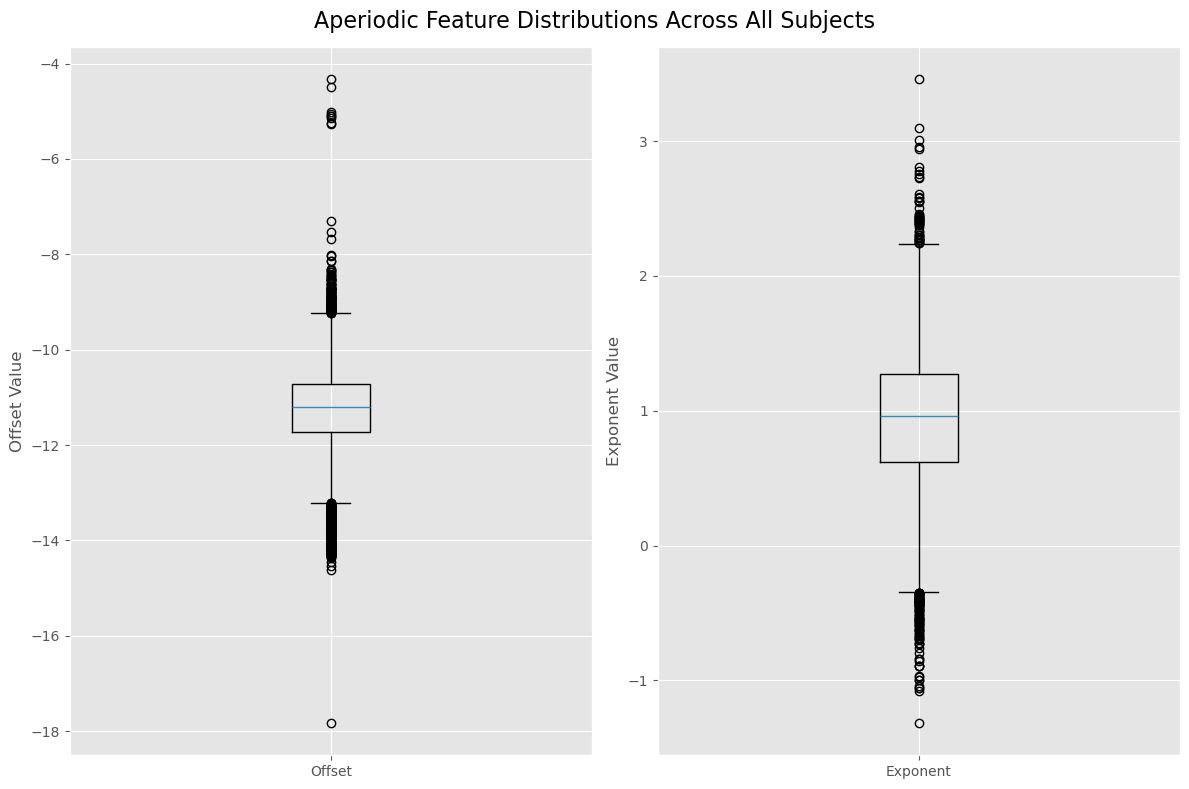

In [69]:
# Box plot for offset and exponent values for all subjects

# Extract all columns for offset and exponent
offset_cols = [col for col in features_superset_df.columns if col.endswith('_offset')]
exponent_cols = [col for col in features_superset_df.columns if col.endswith('_exponent')]

# Stack all offset and exponent values into long arrays
offset_values = features_superset_df[offset_cols].values.flatten()
exponent_values = features_superset_df[exponent_cols].values.flatten()

# Remove NaNs
offset_values = offset_values[~np.isnan(offset_values)]
exponent_values = exponent_values[~np.isnan(exponent_values)]

# Create two side-by-side boxplots for offset and exponent values
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Aperiodic Feature Distributions Across All Subjects', fontsize=16)

# Offset boxplot
axes[0].boxplot(offset_values)
# axes[0].set_title('Aperiodic Offset Spread')
axes[0].set_ylabel('Offset Value')
axes[0].set_xticks([1])
axes[0].set_xticklabels(['Offset'])

# Exponent boxplot
axes[1].boxplot(exponent_values)
# axes[1].set_title('Aperiodic Exponent Spread')
axes[1].set_ylabel('Exponent Value')
axes[1].set_xticks([1])
axes[1].set_xticklabels(['Exponent'])

plt.tight_layout()
plt.show()

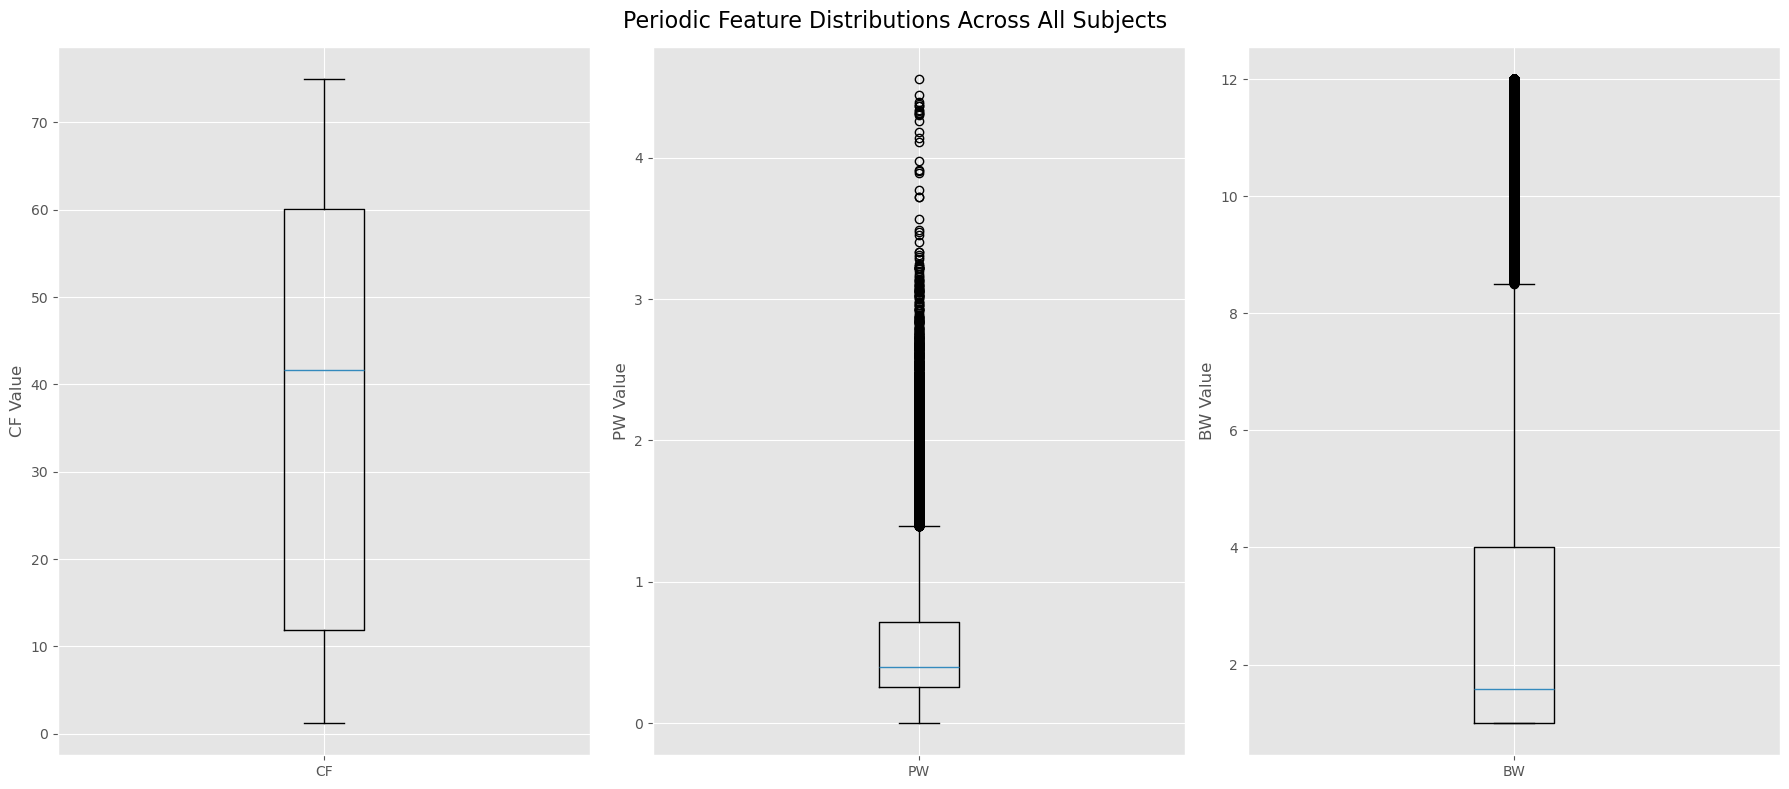

In [67]:
# Box plot for cf, pw, bw values for all subjects

# Extract all columns for cf, pw, bw
cf_cols = [col for col in features_superset_df.columns if '_cf_' in col]
pw_cols = [col for col in features_superset_df.columns if '_pw_' in col]
bw_cols = [col for col in features_superset_df.columns if '_bw_' in col]

# Stack all cf, pw, bw values into long arrays and remove NaNs
cf_values = features_superset_df[cf_cols].values.flatten()
cf_values = cf_values[~np.isnan(cf_values)]

pw_values = features_superset_df[pw_cols].values.flatten()
pw_values = pw_values[~np.isnan(pw_values)]

bw_values = features_superset_df[bw_cols].values.flatten()
bw_values = bw_values[~np.isnan(bw_values)]

# Create three side-by-side boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle('Periodic Feature Distributions Across All Subjects', fontsize=16)

axes[0].boxplot(cf_values)
axes[0].set_ylabel('CF Value')
axes[0].set_xticks([1])
axes[0].set_xticklabels(['CF'])

axes[1].boxplot(pw_values)
axes[1].set_ylabel('PW Value')
axes[1].set_xticks([1])
axes[1].set_xticklabels(['PW'])

axes[2].boxplot(bw_values)
axes[2].set_ylabel('BW Value')
axes[2].set_xticks([1])
axes[2].set_xticklabels(['BW'])

plt.tight_layout()
plt.show()

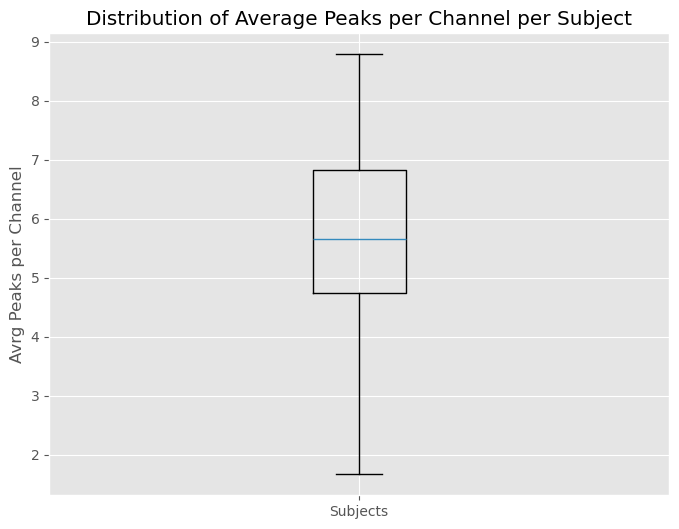

In [74]:
# Calculate the average number of peaks per channel for each subject
avg_peaks_per_channel = num_peaks_per_subject / len(exponent_cols)

plt.figure(figsize=(8, 6))
plt.boxplot(avg_peaks_per_channel)
plt.ylabel('Avrg Peaks per Channel')
plt.title('Distribution of Average Peaks per Channel per Subject')
plt.xticks([1], ['Subjects'])
plt.show()

In [ ]:
# Inspect channel, peaks count

# Channels > expected - trim or reject subjct?
# Distributions - Offset, exponent values
# Distributions - Number of peaks + CF, PW, BW values

63 66 66 660 10.0
    subject_id  aperiodic_diff  periodic_diff
0      Summary              63             10
49     sub-049               1              0
50     sub-050               1              0
65     sub-065               1              0
66     sub-066               1              0
68     sub-068               3              0
69     sub-069               1              0
77     sub-077               1              0
78     sub-078               1              0
79     sub-079               1              0
89     sub-089               1              0
90     sub-090               1              0
91     sub-091               1              0
92     sub-092               1              0
93     sub-093               1              0
94     sub-094               1              0
95     sub-095               1              0
96     sub-096               1              0
97     sub-097               1              0
98     sub-098               1              0
99     sub-099  

In [ ]:
# Summary of the Superset
#

# Calculate number of channels and exponents per subject
def subject_feature_summary(df):
    summary = []
    for idx, row in df.iterrows():


        # Count exponents per channel (features ending with 'exponent')
        exponent_cols = [col for col in chn_cols if col.endswith('exponent')]

        row_no_nan = row.dropna()
        chn_cols_no_nan = [col for col in chn_cols if col in row_no_nan.index]
        exponent_cols = [col for col in chn_cols_no_nan if col.endswith('exponent')]
        num_exponents = len(exponent_cols)
        summary.append({
            'subject_id': row['subject_id'],
            'num_channels': num_channels,
            'num_exponents': num_exponents
        })
    return pd.DataFrame(summary)

subject_summary_df = subject_feature_summary(features_superset_df)

# Print per-subject summary
print(subject_summary_df)

# Calculate and print overall averages and std
avg_channels = subject_summary_df['num_channels'].mean()
std_channels = subject_summary_df['num_channels'].std()
avg_exponents = subject_summary_df['num_exponents'].mean()
std_exponents = subject_summary_df['num_exponents'].std()

print(f"\nAverage channels: {avg_channels:.2f} ± {std_channels:.2f}")
print(f"Average exponents: {avg_exponents:.2f} ± {std_exponents:.2f}")

In [ ]:
# ?? tidy up